In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:

import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except:
        pass


2025-10-20 16:25:48.915395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760977549.101368      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760977549.154177      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ GPU memory growth enabled


In [2]:
base_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

image_paths = []
mask_paths = []

for folder in os.listdir(base_dir):
    path = os.path.join(base_dir, folder)
    if not os.path.isdir(path):
        continue

    imgs = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(".tif") and "_mask" not in f])
    masks = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(".tif") and "_mask" in f])

    image_paths.extend(imgs)
    mask_paths.extend(masks)

print(f"🖼️ Total images: {len(image_paths)}, Masks: {len(mask_paths)}")

assert len(image_paths) == len(mask_paths), "Mismatch between images and masks!"

🖼️ Total images: 3929, Masks: 3929


In [3]:
def label_from_mask(mask_path):
    value = np.max(cv2.imread(mask_path))
    return 1 if value > 0 else 0

labels = [label_from_mask(p) for p in mask_paths]
num_tumor = np.sum(labels)
num_notumor = len(labels) - num_tumor
print(f"🔹 Tumor images: {num_tumor}, 🔸 Not Tumor images: {num_notumor}")

🔹 Tumor images: 1373, 🔸 Not Tumor images: 2556


In [4]:
IMG_SIZE = 256
X, Y = [], []

for img_path, mask_path in zip(image_paths, mask_paths):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"⚠️ Error loading: {img_path}")
        continue

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    img = img / 255.0
    mask = (mask > 0).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    X.append(img)
    Y.append(mask)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print(f" Loaded: Images {X.shape}, Masks {Y.shape}")

 Loaded: Images (3929, 256, 256, 3), Masks (3929, 256, 256, 1)


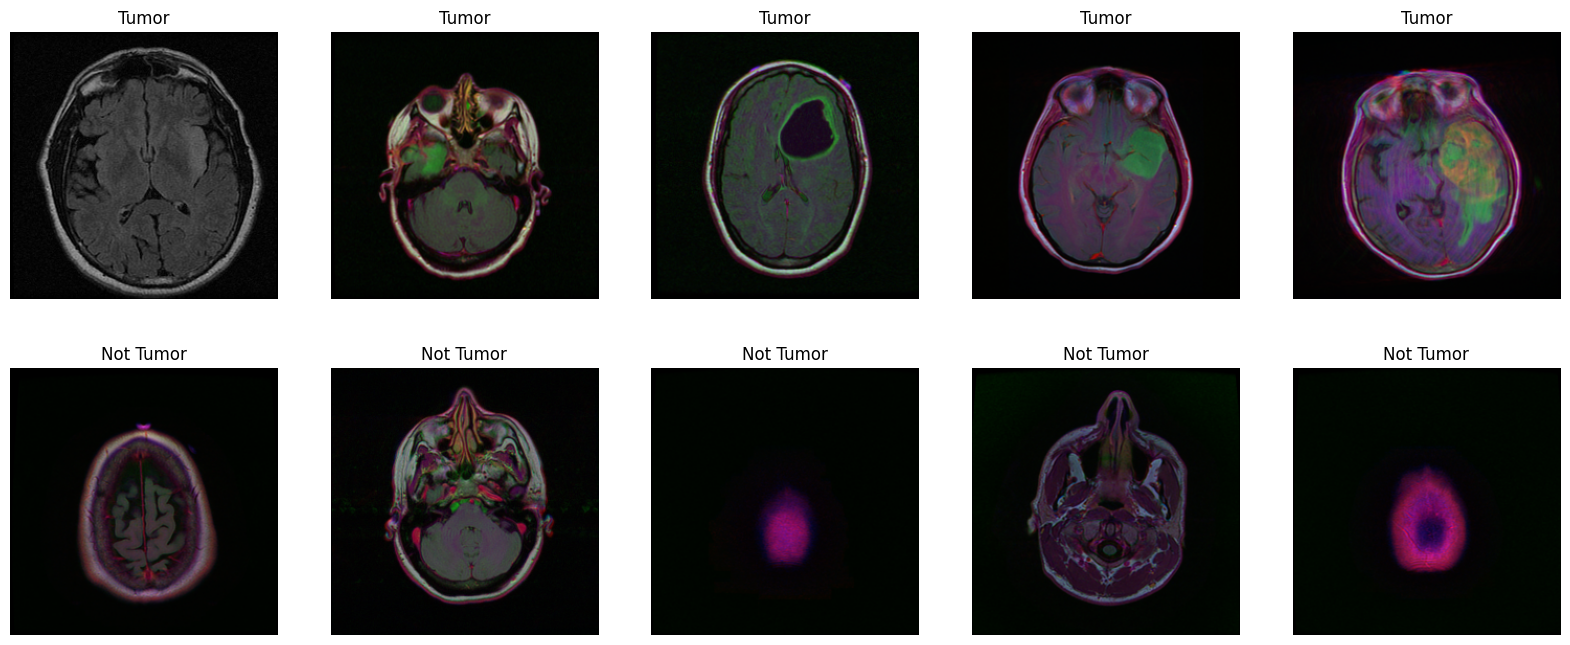

In [5]:
tumor_indices = [i for i, lbl in enumerate(labels) if lbl == 1]
nontumor_indices = [i for i, lbl in enumerate(labels) if lbl == 0]

plt.figure(figsize=(20,8))
for i, idx in enumerate(random.sample(tumor_indices, 5)):
    plt.subplot(2,5,i+1)
    plt.imshow(X[idx])
    plt.axis('off')
    plt.title('Tumor')

for i, idx in enumerate(random.sample(nontumor_indices, 5)):
    plt.subplot(2,5,i+6)
    plt.imshow(X[idx])
    plt.axis('off')
    plt.title('Not Tumor')
plt.show()

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=labels, random_state=42)
print(f" Train: {X_train.shape}, Test: {X_test.shape}")

 Train: (3143, 256, 256, 3), Test: (786, 256, 256, 3)


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical")
])

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    .shuffle(500)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1760977666.277506      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models



from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
c1 = layers.Dropout(0.3)(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Dropout(0.3)(c2)
c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Dropout(0.3)(c3)
c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

# Bottleneck
c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

# Decoder
u5 = layers.UpSampling2D((2, 2))(c4)
u5 = layers.concatenate([u5, c3])
c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
c5 = layers.Dropout(0.3)(c5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

u6 = layers.UpSampling2D((2, 2))(c5)
u6 = layers.concatenate([u6, c2])
c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Dropout(0.3)(c6)
c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

u7 = layers.UpSampling2D((2, 2))(c6)
u7 = layers.concatenate([u7, c1])
c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Dropout(0.3)(c7)
c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

model = models.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_24[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout_6[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │    147,584 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_27[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │    590,080 │ dropout_8[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_29[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_30[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d[0]

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
import tensorflow as tf
from tensorflow.keras import backend as K


# def dice(y_true, y_pred):
#     smooth = 1.
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     return 1 - (2. * intersection + smooth) / (union + smooth)

# def dice_loss(y_true, y_pred):
#     return 1 - dice(y_true, y_pred)
# def iou_metric(y_true, y_pred, threshold=0.5):
#     y_pred = tf.cast(y_pred > threshold, tf.float32)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
#     return intersection / (union + K.epsilon())
# def bce_dice_loss(y_true, y_pred):
#     bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#     return bce + dice_loss(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    smooth = 0.1
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, threshold=0.7):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reduce_mean(bce)  # Average BCE over batch
    return bce + dice_loss(y_true, y_pred)



In [43]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss=bce_dice_loss, 
    metrics=[
        'accuracy',
        iou_metric,
        dice_coefficient  # Add this to monitor
    ]
)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_unet_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)
]

In [45]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 109s 243ms/step - accuracy: 0.9760 - dice_coefficient: 0.1181 - iou_metric: 0.0221 - loss: 0.9466 - val_accuracy: 0.9844 - val_dice_coefficient: 0.2261 - val_iou_metric: 0.2090 - val_loss: 0.8189 - learning_rate: 1.0000e-04
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 88s 223ms/step - accuracy: 0.9810 - dice_coefficient: 0.1194 - iou_metric: 0.0661 - loss: 0.9419 - val_accuracy: 0.9882 - val_dice_coefficient: 0.1997 - val_iou_metric: 0.2274 - val_loss: 0.8479 - learning_rate: 1.0000e-04
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 88s 225ms/step - accuracy: 0.9805 - dice_coefficient: 0.1365 - iou_metric: 0.0797 - loss: 0.9272 - val_accuracy: 0.9902 - val_dice_coefficient: 0.2315 - val_iou_metric: 0.2072 - val_loss: 0.8058 - learning_rate: 1.0000e-04
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 88s 224ms/step - accuracy: 0.9807 - dice_coefficient: 0.1419 - iou_metric: 0.0892 - loss: 0.9190 - val_accuracy: 0.9901 - val_dice_coefficient: 0.1619 - val_iou_metric: 0

In [47]:
y_pred = model.predict(X_test, batch_size=8)
y_pred = (y_pred > 0.5).astype(np.float32)

smooth = 1e-6
dice_scores, iou_scores, acc_scores = [], [], []

for i in range(len(Y_test)):
    y_true = Y_test[i].flatten()
    y_p = y_pred[i].flatten()

    intersection = np.sum(y_true * y_p)
    dice = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_p) + smooth)
    iou = (intersection + smooth) / (np.sum(y_true + y_p) - intersection + smooth)
    acc = np.mean(y_true == y_p)

    dice_scores.append(dice)
    iou_scores.append(iou)
    acc_scores.append(acc)

print(f" Mean Dice: {np.mean(dice_scores):.4f}")
print(f" Mean IoU : {np.mean(iou_scores):.4f}")
print(f" Mean Acc : {np.mean(acc_scores):.4f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step
 Mean Dice: 0.7024
 Mean IoU : 0.6750
 Mean Acc : 0.9877


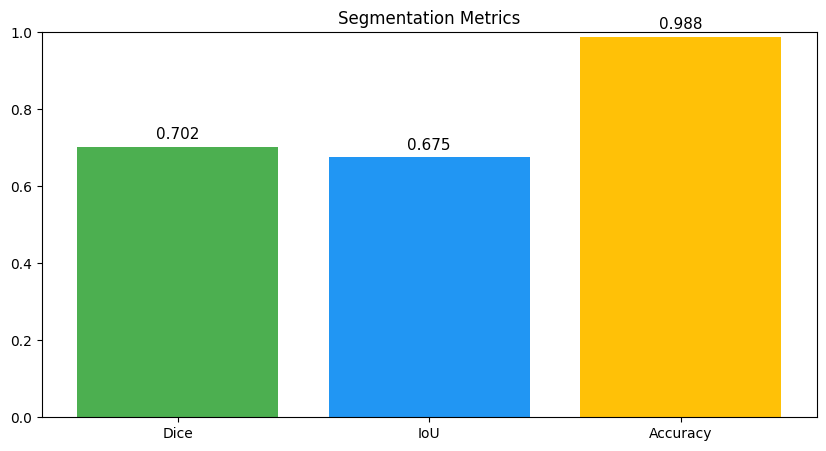

In [48]:
metrics = ['Dice', 'IoU', 'Accuracy']
values = [np.mean(dice_scores), np.mean(iou_scores), np.mean(acc_scores)]

plt.figure(figsize=(10,5))
plt.bar(metrics, values, color=['#4CAF50','#2196F3','#FFC107'])
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.3f}", ha='center', fontsize=11)
plt.ylim(0,1)
plt.title("Segmentation Metrics")
plt.show()

/tmp/ipykernel_37/2515828812.py:31: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  plt.tight_layout()


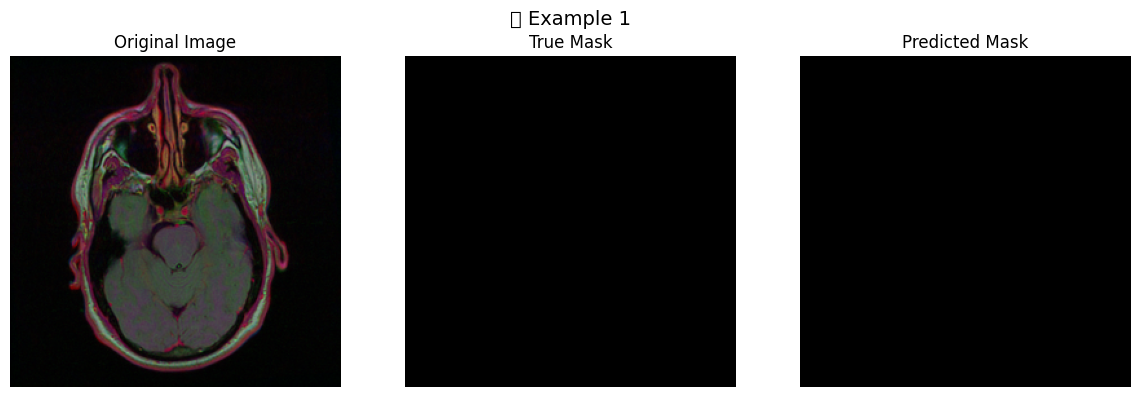

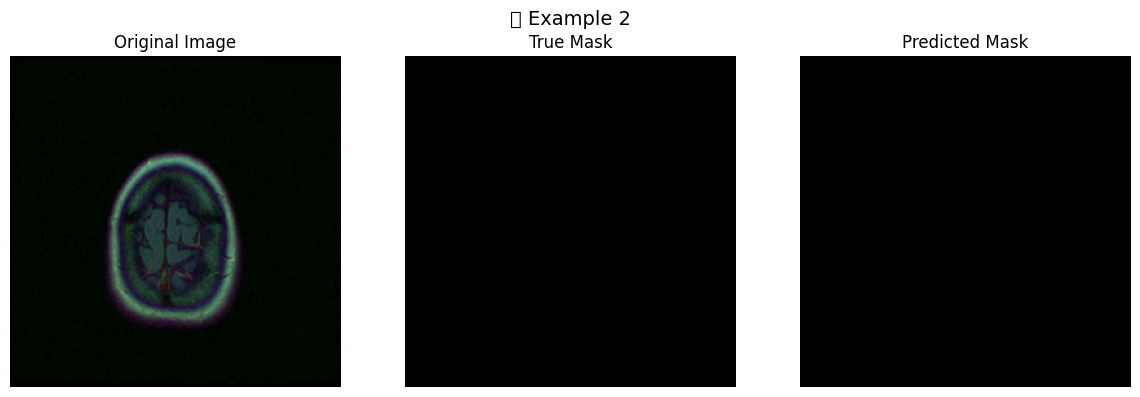

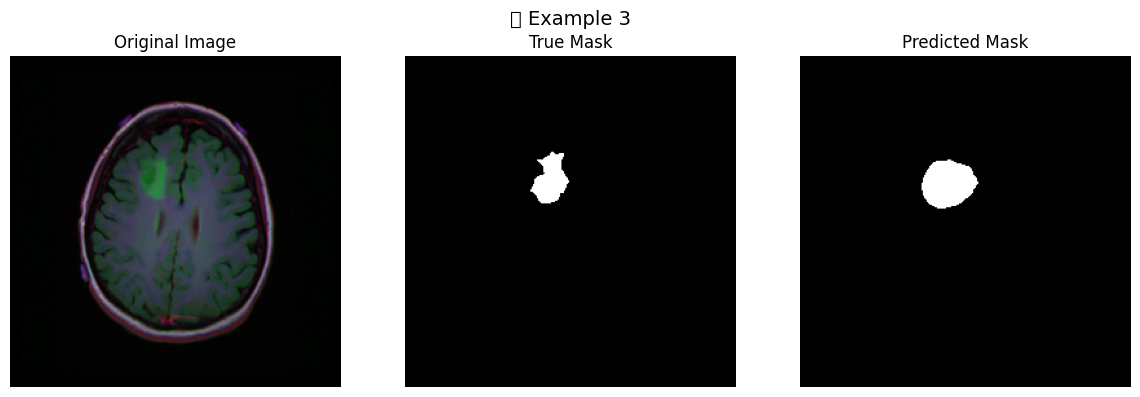

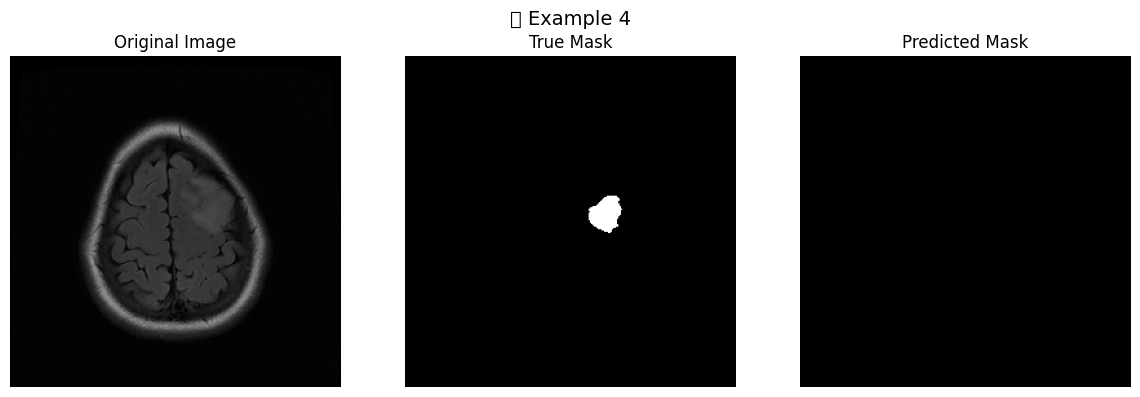

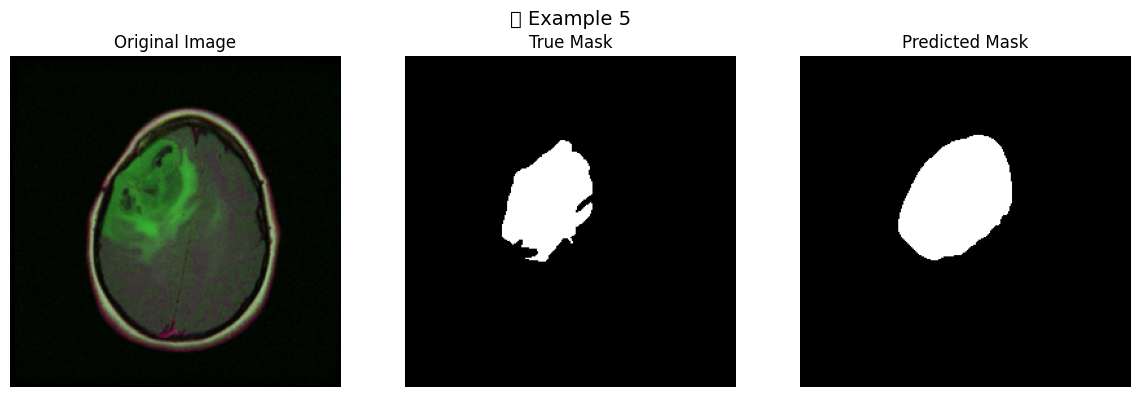

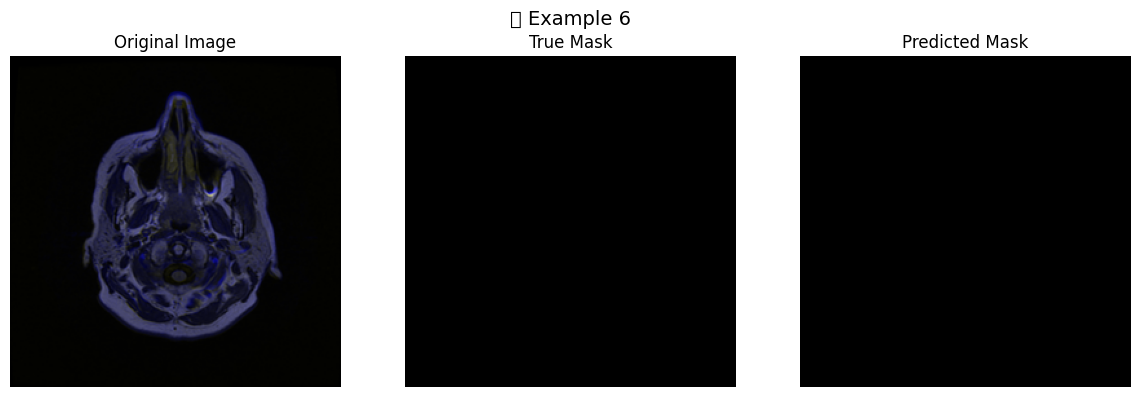

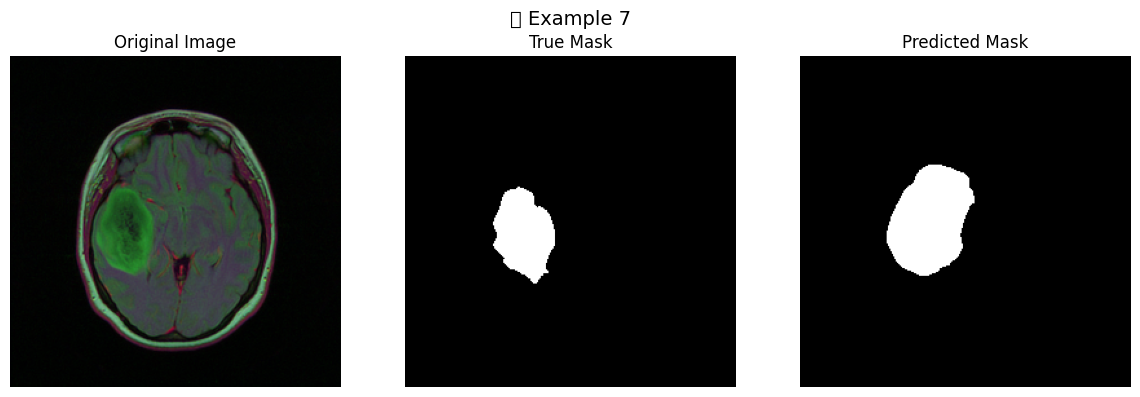

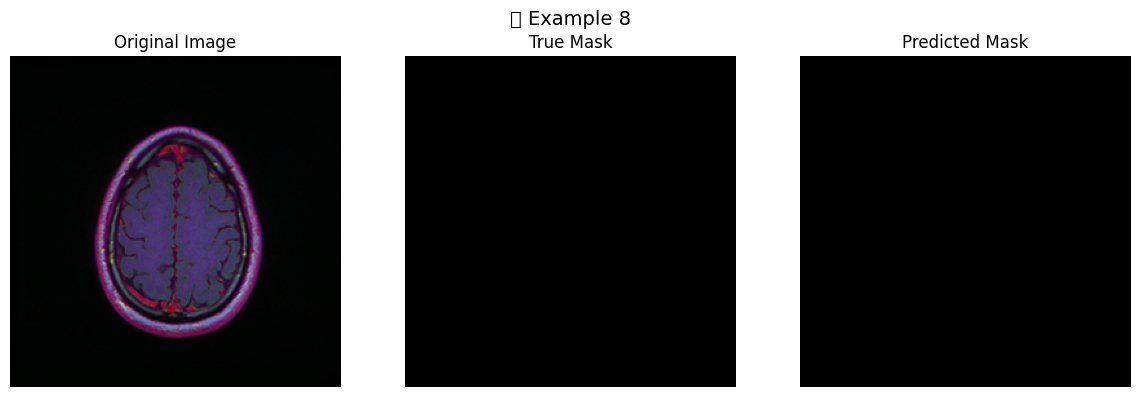

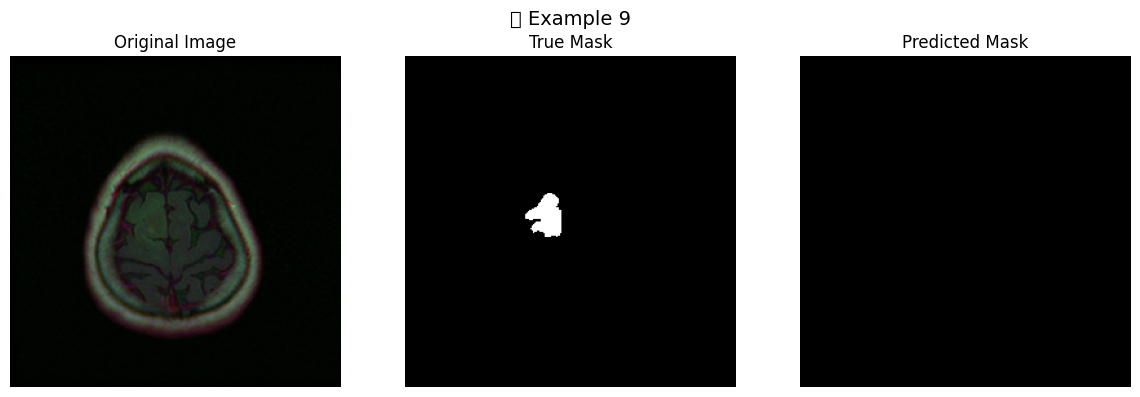

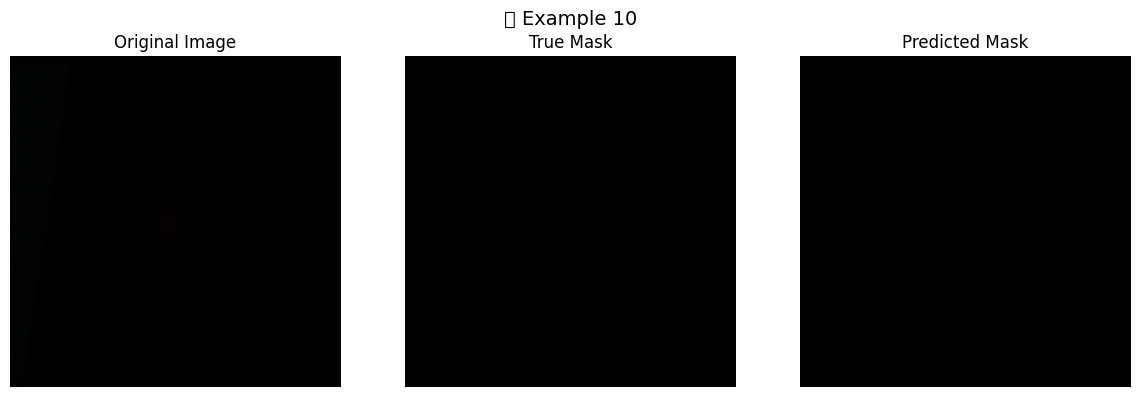

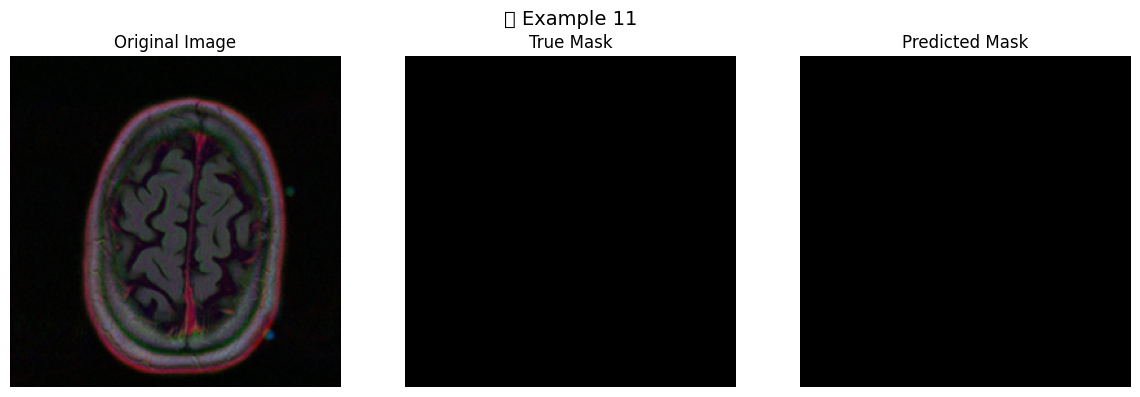

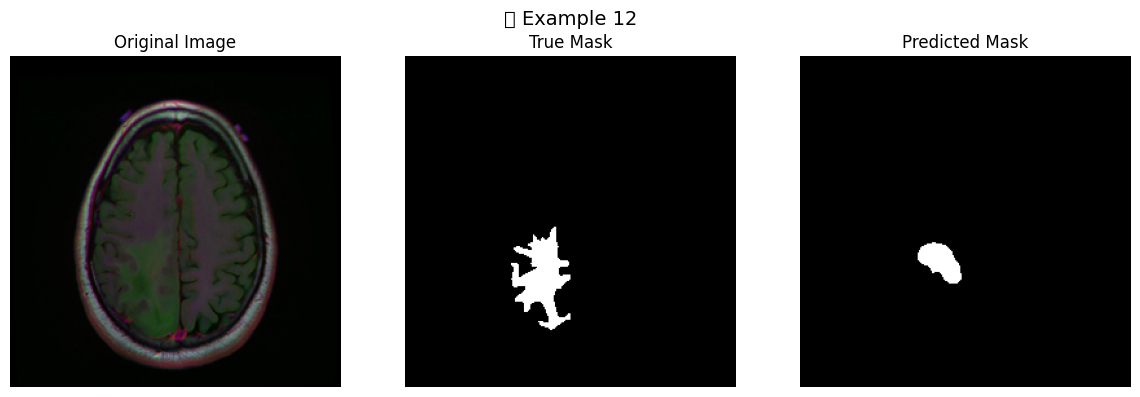

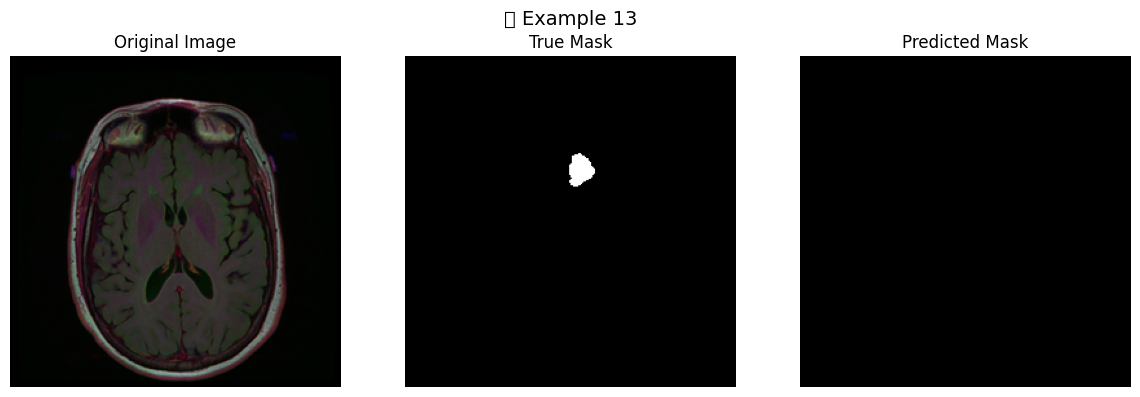

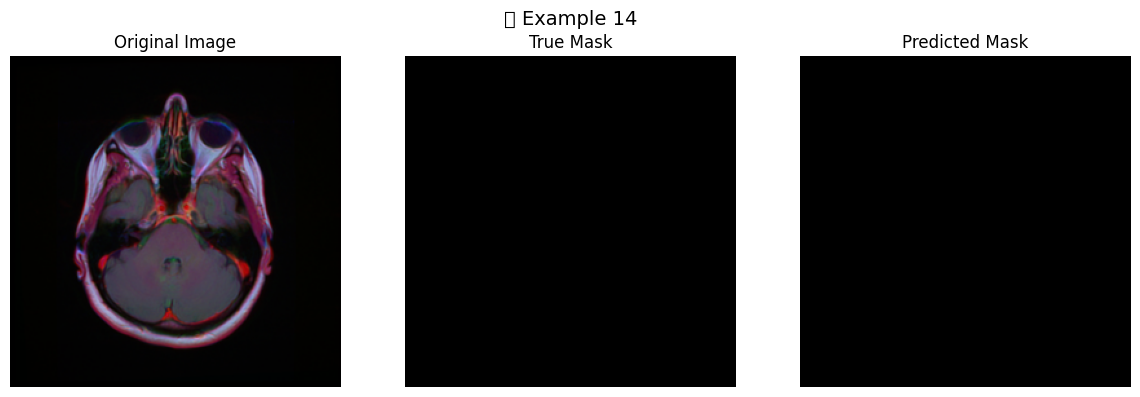

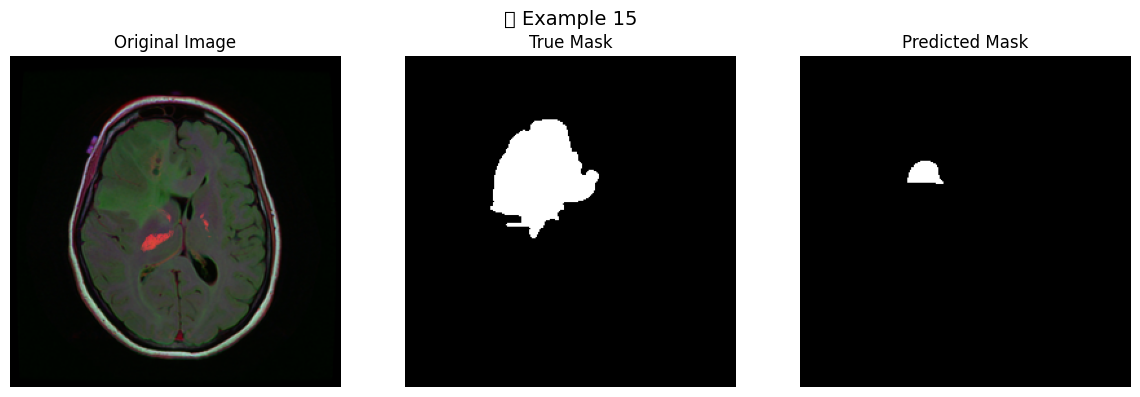

In [64]:

num_examples = 15

for i in range(num_examples):
    idx = random.randint(0, len(X_test) - 1)
    
    sample_img = X_test[idx]
    sample_mask_true = Y_test[idx]
    sample_mask_pred = y_pred[idx]

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"🔹 Example {i+1}", fontsize=14)

  
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img)
    plt.title("Original Image")
    plt.axis('off')

   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_mask_true[:, :, 0], cmap='gray')
    plt.title("True Mask")
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.imshow(sample_mask_pred[:, :, 0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [65]:
model.save("unet_brain_tumor_final.h5")
print("✅ Model saved as unet_brain_tumor_final.h5")

✅ Model saved as unet_brain_tumor_final.h5


In [67]:
import cv2

def draw_bounding_boxes(image, mask, min_area=200):

    img = (image * 255).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8)

 
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxed_img = img.copy()

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area: 
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(boxed_img, f"Area:{int(area)}", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return boxed_img

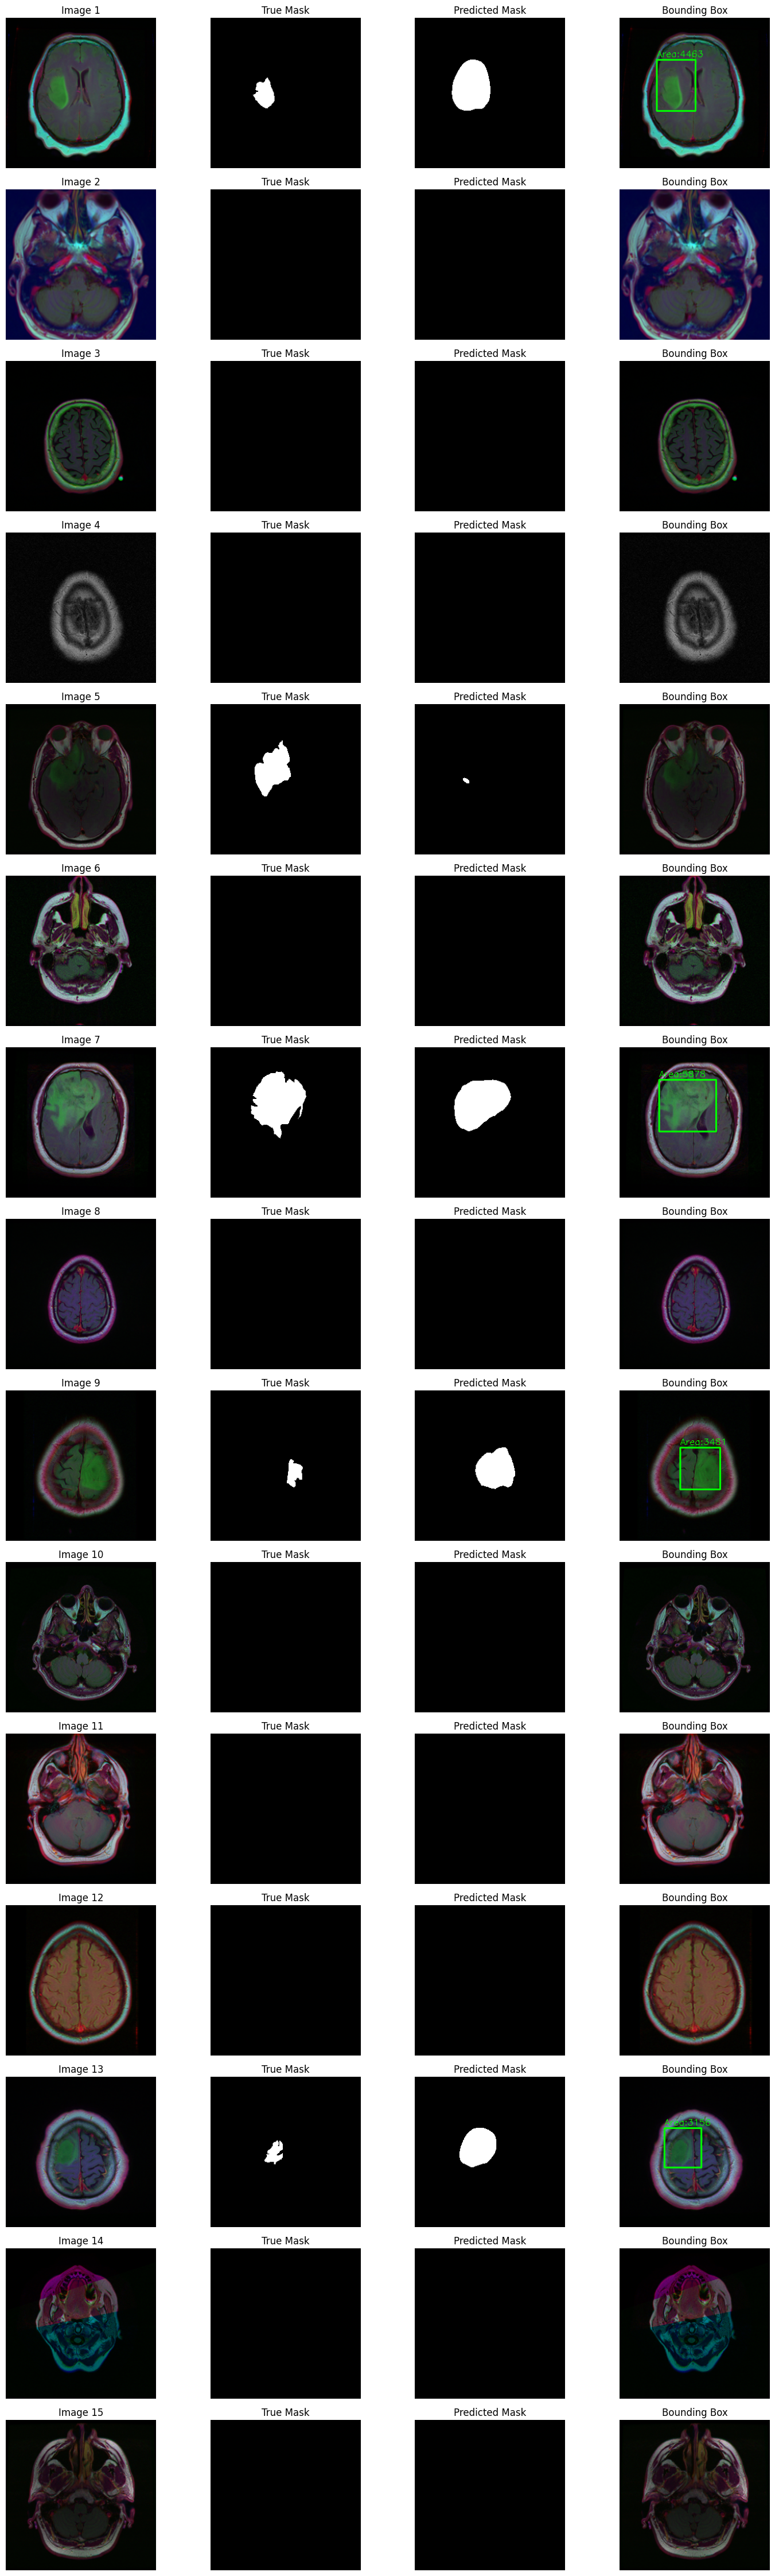

In [69]:
import matplotlib.pyplot as plt
import random


num_samples = 15  

plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    
    idx = random.randint(0, len(X_test) - 1)
    sample_img = X_test[idx]
    sample_mask_true = Y_test[idx]
    sample_mask_pred = y_pred[idx]

  
    boxed_result = draw_bounding_boxes(sample_img, sample_mask_pred[:, :, 0])

  
    plt.subplot(num_samples, 4, i * 4 + 1)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.title(f"Image {i+1}")

    plt.subplot(num_samples, 4, i * 4 + 2)
    plt.imshow(sample_mask_true[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("True Mask")

    plt.subplot(num_samples, 4, i * 4 + 3)
    plt.imshow(sample_mask_pred[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("Predicted Mask")

    plt.subplot(num_samples, 4, i * 4 + 4)
    plt.imshow(boxed_result)
    plt.axis('off')
    plt.title("Bounding Box")

plt.tight_layout()
plt.show()
